# Concrete

In [2]:
# set python to pick up local directory
from pathlib import Path
import sys
import os
path_root = Path(os.getcwd()).parents[0]
sys.path.append(str(path_root))
sys.path.append(str(Path(os.getcwd()).parents[1]))

%reload_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('always', category=FutureWarning)

In [3]:
from jax import config
config.update("jax_enable_x64", True)

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [5]:
import jax
import jax.numpy as jnp
from jax import vmap, jit
from tensorflow_probability.substrates.jax import distributions as tfd
import optax
import equinox as eqx
from jax.lib import xla_bridge

In [6]:
from steinRF.utils import gp_cross_val, metric_model, run_hyperopt, train_test_split
from steinRF.baselines import build_train_svgp, svgp_predict, svgp_cross_val, svgp_nlpd
from steinRF.stein.targets import TFTarget
from steinRF.gp.models import *

In [7]:
jax.clear_caches()
print(f"device: {xla_bridge.get_backend().platform}")

device: gpu


## Data Preparation

In [8]:
key = jax.random.PRNGKey(0)

In [9]:
concrete = pd.read_csv("concrete.csv")
X_scaler = MinMaxScaler()
y_scaler = StandardScaler()

X_cols = [col for col in concrete.columns if col != "compressive_strength"]
concrete[X_cols] = X_scaler.fit_transform(concrete[X_cols])
concrete["compressive_strength"] = y_scaler.fit_transform(concrete[["compressive_strength"]])

X = jnp.array(concrete.drop(columns=['compressive_strength']))
y = jnp.array(concrete['compressive_strength'])
X_train, X_val, y_train, y_val = train_test_split(key, X, y, test_size=0.2)

d = X_train.shape[1]

## Hyperparameter Optimization

In [9]:
# total settings
diag_min, diag_max = 1e-4, 1e-1
epoch_min, epoch_max = 500, 4000
lr_min, lr_max = 1e-3, 4e-1
alpha_min, alpha_max = 0., 3.
q_min, q_max = 2, 10
s_vals = [0, 0.5, 1, 2]


# --------------------------------- Sparse Variational GP -------------------------------- #
def _svgp_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.get('R')
    diag = params.get('diag', None)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", 5e-4, 0.1, log=True)
    cv_params = {'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, **params}

    # run cross val
    cross_val_acc = svgp_cross_val(key, X, y, cv_params)
    return cross_val_acc


# ---------------------------------- RFF GP - RBF Kernel --------------------------------- #
def rff_rbf_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.pop('R')
    diag = params.pop('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    cv_params = {'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, **params}

    # run cross val
    cross_val_acc = gp_cross_val(build_train_rff_rbf, key, X, y, cv_params)
    return cross_val_acc


# --------------------------------------- RFF BASIC -------------------------------------- #
def rff_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.pop('R')
    diag = params.pop('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    cv_params = {'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, **params}

    # run cross val
    cross_val_acc = gp_cross_val(build_train_rff, key, X, y, cv_params)
    return cross_val_acc


# --------------------------------------- STEIN RFF -------------------------------------- #
def srf_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.pop('R')

    diag = params.pop('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    lr_gd = params.pop('lr_gd', None)
    if lr_gd is None:
        lr_gd = trial.suggest_float("lr_gd", lr_min, lr_max, log=True)
    alpha = params.pop('alpha', None)
    if alpha is None:
        alpha = trial.suggest_float("alpha", alpha_min, alpha_max, step=0.2)
    s = params.pop('s', None)
    if s is None:
        s = trial.suggest_categorical("s", s_vals)
    cv_params = {
        'R': R, 'epochs': epochs, 'lr': lr, 'lr_gd': lr_gd, 'diag': diag, 'alpha': alpha, 
        's': s, **params
    }
    # cv_params = {
    #     'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, 'alpha': alpha, 
    #     's': s, **params
    # }

    # run cross val
    cross_val_acc = gp_cross_val(build_train_srf, key, X, y, cv_params)
    return cross_val_acc


# ------------------------------------ MARGINAL KERNEL ----------------------------------- #
def mix_rff_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.pop('R')

    diag = params.pop('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    lr_gd = params.pop('lr_gd', None)
    if lr_gd is None:
        lr_gd = trial.suggest_float("lr_gd", lr_min, lr_max, log=True)
    alpha = params.pop('alpha', None)
    if alpha is None:
        alpha = trial.suggest_float("alpha", alpha_min, alpha_max, step=0.2)
    q = params.pop('q', None)
    if q is None:
        q = trial.suggest_int("q", q_min, q_max, step=2)
    s = params.pop('s', None)
    if s is None:
        s = trial.suggest_categorical("s", s_vals)

    cv_params = {
        'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, 'lr_gd': lr_gd,
        'alpha': alpha, 's': s, 'q': q, 'kernel': 'rbf', **params
    }

    # run cross val
    n_folds = params.pop('n_folds', 5)
    cross_val_acc = gp_cross_val(build_train_mix_rff, key, X, y, cv_params, n_folds=n_folds)
    return cross_val_acc



### Run Optimization

In [10]:
n_trials = 30
R = 100
hparams = {}

#### Sparse-Variational GP

In [10]:
# svgp = build_train_svgp(key, X, y, R=R, diag=1e-2, epochs=1000, lr=0.01, from_data=True)[0]
svgp_study = run_hyperopt(
    _svgp_cross_val, key, X_train, y_train, n_trials=n_trials, R=R, diag=1e-2, from_data=False, epochs=1000
)
hparams["svgp"] = svgp_study.best_params

[I 2024-02-10 01:34:48,562] A new study created in memory with name: no-name-60b00659-9b5a-4843-8911-372d520e2288


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-02-10 01:35:25,090] Trial 0 finished with value: 0.3684043744747548 and parameters: {'lr': 0.0006728018524728593}. Best is trial 0 with value: 0.3684043744747548.
[I 2024-02-10 01:35:56,565] Trial 1 finished with value: 0.19670388557321522 and parameters: {'lr': 0.07920197843656476}. Best is trial 1 with value: 0.19670388557321522.
[I 2024-02-10 01:36:27,302] Trial 2 finished with value: 0.23411662457014418 and parameters: {'lr': 0.001567476042144662}. Best is trial 1 with value: 0.19670388557321522.
[I 2024-02-10 01:36:58,235] Trial 3 finished with value: 0.20444573559830231 and parameters: {'lr': 0.004180130757767301}. Best is trial 1 with value: 0.19670388557321522.
[I 2024-02-10 01:37:29,357] Trial 4 finished with value: 0.4024862814342782 and parameters: {'lr': 0.0005805878779183577}. Best is trial 1 with value: 0.19670388557321522.
[I 2024-02-10 01:38:00,581] Trial 5 finished with value: 0.16709677968953224 and parameters: {'lr': 0.018994658441233388}. Best is trial 5 wit

#### RFF with RBF

In [ ]:
# rff_rbf = build_train_rff_rbf(key, X_train, R=100, diag=1e-2, epochs=1000, lr=0.01, from_data=False)[0]
rff_rbf_study = run_hyperopt(
    rff_rbf_cross_val, key, X_train, y_train, n_trials=n_trials, R=R, epochs=1000, init_ls=False
)
hparams["rff_rbf"] = rff_rbf_study.best_params

#### Basic RFF GP

In [11]:
# rff = build_train_rff(key, X_train, y_train, R=R, diag=0.09, epochs=2000, lr=.013, from_data=False, init_ls=False)[0]
rff_study = run_hyperopt(
    rff_cross_val, key, X_train, y_train, n_trials=n_trials, R=R, epochs=1000, from_data=False, init_ls=False
)
hparams["rff"] = rff_study.best_params

[I 2024-02-10 02:01:14,493] A new study created in memory with name: no-name-3f7c95e5-686b-460f-999e-8539b79b48e6


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-02-10 02:01:31,059] Trial 0 finished with value: 0.3130512038124511 and parameters: {'diag': 0.00011899057245427316, 'lr': 0.17639032540647825}. Best is trial 0 with value: 0.3130512038124511.
[I 2024-02-10 02:01:45,733] Trial 1 finished with value: 0.1276076855572909 and parameters: {'diag': 0.030822676516862647, 'lr': 0.00987201891888893}. Best is trial 1 with value: 0.1276076855572909.
[I 2024-02-10 02:02:00,503] Trial 2 finished with value: 1.009601344360198 and parameters: {'diag': 0.00015793581531171045, 'lr': 0.0117777584502081}. Best is trial 1 with value: 0.1276076855572909.
[I 2024-02-10 02:02:15,286] Trial 3 finished with value: 0.11582558453854805 and parameters: {'diag': 0.05854497803653283, 'lr': 0.009455215905141085}. Best is trial 3 with value: 0.11582558453854805.
[I 2024-02-10 02:02:30,044] Trial 4 finished with value: 0.4859430112313782 and parameters: {'diag': 0.0006317727820432532, 'lr': 0.026329004009463197}. Best is trial 3 with value: 0.11582558453854805

#### Stein Random Features

In [12]:
# srf = build_train_srf(key, X_train, y_train, R=R, diag=1e-3, epochs=1000, lr=0.1, alpha=0.5, s=0.5, from_data=False, init_ls=False)[0]
srf_study = run_hyperopt(
    srf_cross_val, key, X_train, y_train, n_trials=50, R=R, epochs=1000, from_data=False, init_ls=False,
    gd_params=lambda t: [t.kernel.transform.scale]
)
hparams["srf"] = srf_study.best_params

[I 2024-02-10 02:08:53,523] A new study created in memory with name: no-name-495170fe-e384-444c-bf0b-c0e534ce3801


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-02-10 02:09:12,337] Trial 0 finished with value: 0.5865822960073148 and parameters: {'diag': 0.00024282177812108373, 'lr': 0.00644087337919752, 'lr_gd': 0.052595922878610715, 'alpha': 0.0, 's': 2}. Best is trial 0 with value: 0.5865822960073148.
[I 2024-02-10 02:09:29,950] Trial 1 finished with value: 0.1701304637574811 and parameters: {'diag': 0.014154012553906711, 'lr': 0.0022194712558587758, 'lr_gd': 0.0028390487894859625, 'alpha': 2.6, 's': 0}. Best is trial 1 with value: 0.1701304637574811.
[I 2024-02-10 02:09:48,220] Trial 2 finished with value: 0.1952352102886128 and parameters: {'diag': 0.00755509061274433, 'lr': 0.08952762005592099, 'lr_gd': 0.0038011188576371198, 'alpha': 0.0, 's': 0}. Best is trial 1 with value: 0.1701304637574811.
[I 2024-02-10 02:10:05,888] Trial 3 finished with value: 0.6386056788632002 and parameters: {'diag': 0.00013332915515950507, 'lr': 0.0015787554554618452, 'lr_gd': 0.02002046909385376, 'alpha': 3.0, 's': 0.5}. Best is trial 1 with value: 0.

#### Mixture SRFR

In [12]:
prior = TFTarget(tfd.Normal(jnp.zeros(d), jnp.ones(d) * 3))
mix_rff_study = run_hyperopt(
    mix_rff_cross_val, key, X_train, y_train, n_trials=40, R=R, epochs=1000, from_data=False, prior=prior,
    gd_params=lambda t: [t.kernel.transform.scale], init_ls=False, q=6
)

[I 2024-06-01 18:17:51,414] A new study created in memory with name: no-name-76e922be-b696-4ac2-a4d9-385f608a776f


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2024-06-01 18:19:24,235] Trial 0 finished with value: 0.24776656539921316 and parameters: {'diag': 0.0012428451486594671, 'lr': 0.103057324350968, 'lr_gd': 0.0020365769589328403, 'alpha': 0.0, 's': 0}. Best is trial 0 with value: 0.24776656539921316.
[I 2024-06-01 18:20:54,980] Trial 1 finished with value: 0.08332534662032129 and parameters: {'diag': 0.011862472508387515, 'lr': 0.3875468539371557, 'lr_gd': 0.30558624467662193, 'alpha': 0.0, 's': 1}. Best is trial 1 with value: 0.08332534662032129.
[I 2024-06-01 18:22:25,880] Trial 2 finished with value: 0.2137086979451115 and parameters: {'diag': 0.004518481649194404, 'lr': 0.06514194350648203, 'lr_gd': 0.21068101226387465, 'alpha': 1.0, 's': 0.5}. Best is trial 1 with value: 0.08332534662032129.
[I 2024-06-01 18:23:56,700] Trial 3 finished with value: 0.1759023008895289 and parameters: {'diag': 0.002318174123226755, 'lr': 0.14616666323852812, 'lr_gd': 0.39635247374347543, 'alpha': 1.8, 's': 0.5}. Best is trial 1 with value: 0.08332

## Define and Run Experiment

### Definition

In [9]:
def experiment_run(exp_key, X, y, scaler, params, R, restarts=1):    
    # split data
    X_tr, X_test, y_tr, y_test = train_test_split(exp_key, X, y, test_size=0.1)

    ############ SVGP ############
    svgp, _ = build_train_svgp(exp_key, X_tr, y_tr, R=R, **params["svgp"])
    svgp_preds, svgp_sd = svgp_predict(svgp, X_test)
    svgp_metrics = metric_model(y_test, svgp_preds, svgp_sd, scaler=scaler)
    svgp_metrics = jnp.concatenate([svgp_metrics, jnp.atleast_1d(svgp_nlpd(svgp, X_test, y_test))])

    ############ RFF RBF ############
    rff_rbf_gp, _ = build_train_rff_rbf(exp_key, X_tr, y_tr, R=R, restarts=restarts, **params["rff_rbf"])
    rff_rbf_preds, rff_rbf_sd = rff_rbf_gp.condition(y_tr, X_test)
    rff_rbf_metrics = metric_model(y_test, rff_rbf_preds, rff_rbf_sd, scaler=scaler)
    rff_rbf_metrics = jnp.concatenate([
        rff_rbf_metrics, jnp.atleast_1d(rff_rbf_gp.nlpd(y_tr, X_test, y_test))
    ])

    ############ RFF ############
    rff_gp, _ = build_train_rff(exp_key, X_tr, y_tr, R=R, restarts=restarts, **params["rff"])
    rff_preds, rff_sd = rff_gp.condition(y_tr, X_test)
    rff_metrics = metric_model(y_test, rff_preds, rff_sd, scaler=scaler)
    rff_metrics = jnp.concatenate([
        rff_metrics, jnp.atleast_1d(rff_gp.nlpd(y_tr, X_test, y_test))
    ])

    ############ RFF-Q ############
    # RFF with the equilvalent number of R as the computational complexity of the mixture.
    q = params["mix_rff"]["q"]
    R_equiv_q = int((q * R**3)**(1/3))
    qrff_gp, _ = build_train_rff(exp_key, X_tr, y_tr, R=R_equiv_q, restarts=restarts, **params["rff"])
    qrff_preds, qrff_sd = qrff_gp.condition(y_tr, X_test)
    qrff_metrics = metric_model(y_test, qrff_preds, qrff_sd, scaler=scaler)
    qrff_metrics = jnp.concatenate([
        qrff_metrics, jnp.atleast_1d(qrff_gp.nlpd(y_tr, X_test, y_test))
    ])

    ############ SRF ############
    srf_gp, _ = build_train_srf(exp_key, X_tr, y_tr, R=R, restarts=restarts, **params["srf"])
    srf_preds, srf_sd = srf_gp.condition(y_tr, X_test)
    srf_metrics = metric_model(y_test, srf_preds, srf_sd, scaler=scaler)
    srf_metrics = jnp.concatenate([
        srf_metrics, jnp.atleast_1d(srf_gp.nlpd(y_tr, X_test, y_test))
    ])    

    ############ MIX ############
    mix_gp, _ = build_train_mix_rff(exp_key, X_tr, y_tr, R=R, restarts=restarts, **params["mix_rff"])
    mix_preds, mix_sd = mix_gp.condition(y_tr, X_test)
    mix_metrics = metric_model(y_test, mix_preds, mix_sd, scaler=scaler)
    mix_metrics = jnp.concatenate([
        mix_metrics, jnp.atleast_1d(mix_gp.nlpd(y_tr, X_test, y_test))
    ])

    metrics = {
        "seed": exp_key[1],
        "svgp": svgp_metrics,
        "rff_rbf": rff_rbf_metrics,
        "rff": rff_metrics,
        "qrff": qrff_metrics,
        "srf": srf_metrics,
        "mix": mix_metrics,
    }

    return metrics

In [10]:
def multi_run(multi_key, X, y, scaler, params, R, n_runs=10):
    metrics = []
    run_keys = jax.random.split(multi_key, n_runs)

    for i in range(n_runs):
        print(f"Running experiment {i+1} of {n_runs}")
        run_res = experiment_run(run_keys[i], X, y, scaler, params, R)
        metrics.append(run_res)
        print(run_res)
    
    return metrics

### Run

In [11]:
# parameters
KEY, subkey = jax.random.split(jax.random.PRNGKey(2024))
params = {
    "svgp": {'epochs': 1000, 'lr':  0.03943006189843416, 'diag': 0.01, 'from_data': False},  # not done
    "rff_rbf": {'diag': 0.09557277712120715, 'lr': 0.3673756353254991, 'epochs': 1000, 'init_ls': False}, # done
    "rff": {'diag': 0.08941600525463213, 'lr': 0.013028342062540154, 'epochs': 1000, 'from_data': False, 'init_ls': False},  # done
    "srf": {
        'diag': 0.09605792010056687, 'lr': 0.01821058468763105, 'lr_gd': 0.013285678053308094, 'alpha': 2.4, 's': 1,  # not done
        'epochs': 1000, 'from_data': False, 'gd_params': lambda t: [t.kernel.transform.scale], 'init_ls': False
    },
    "mix_rff": {
        # 'diag': 0.04158413731186824, 'lr': 0.342489358101857, 'lr_gd': 0.15121439497743513, 'alpha': 0.4, 'q': 6, 's': 1,  # old params
        'diag': 0.011862472508387515, 'lr': 0.3875468539371557, 'lr_gd': 0.30558624467662193, 'alpha': 0.0, 's': 1, 'q': 6,
        'epochs': 1000, 'from_data': False, 'gd_params': lambda t: [t.kernel.transform.scale], 'init_ls': False,
        'prior': TFTarget(tfd.Normal(jnp.zeros(d), jnp.ones(d) * 3))
    },
}

In [16]:
# experiment_run(subkey, X_val, y_val, y_scaler, params, R)
res = multi_run(KEY, X, y, y_scaler, params, R=100, n_runs=10)

Running experiment 1 of 10
{'seed': Array(3007921430, dtype=uint32), 'svgp': Array([ 4.12160454e+01,  4.76850522e+00,  9.51456308e-01, -4.94802067e-03,
        2.17299639e+02], dtype=float64), 'rff_rbf': Array([ 3.55804430e+01,  4.67921364e+00,  9.61165071e-01, -1.36526753e-02,
        3.95920093e+01], dtype=float64), 'rff': Array([ 3.25006806e+01,  3.72076805e+00,  9.12621379e-01, -1.39075111e-02,
        3.45243711e+01], dtype=float64), 'qrff': Array([ 1.95986083e+01,  3.11120923e+00,  9.70873773e-01, -1.17943820e-02,
        1.13069058e+01], dtype=float64), 'srf': Array([ 3.17146431e+01,  4.09164365e+00,  9.41747606e-01, -2.06323430e-02,
        2.87179945e+01], dtype=float64), 'mix': Array([ 1.89569252e+01,  2.97285240e+00,  8.73786390e-01, -8.28951775e-03,
        1.20219693e+02], dtype=float64)}
Running experiment 2 of 10
{'seed': Array(2158071644, dtype=uint32), 'svgp': Array([6.39647875e+01, 6.00611845e+00, 9.02912617e-01, 1.05841267e-02,
       5.36180882e+02], dtype=float64),

In [17]:
res_df = []
for exp in res:
    res_df.extend([[k, *v.tolist()] for k,v in exp.items() if k != "seed"])
res_df = pd.DataFrame(res_df, columns=["model", "mse", "mae", "cal", "z", "nlpd"])
res_df.to_csv("results_cr.csv", index=False)

## Evaluate

In [18]:
res_df = pd.read_csv("results_cr.csv")

names = {
    "rff": "RFF",
    "nrff": "Nonstationary RFF",
    "rff_rbf": "RFF-RBF",
    "svgp": "Sparse VGP",
    "srf": "Stein RFF",
    "qrff": "RFF Equiv Mix Big-O",
    "mix": "Stein Mixture RFF",
    "nmix": "Nonstationary Stein Mixture RFF",
}

res_df["model"] = res_df["model"].apply(lambda x: names[x])
res_df["rmse"] = np.sqrt(res_df["mse"])
res_df["log_mse"] = np.log(res_df["mse"])

In [21]:
sum_df = res_df.groupby("model").agg(["mean", "std"])
sum_df.columns = sum_df.columns.map(lambda x: '_'.join(x) if isinstance(x, tuple) else x)
sum_df = sum_df.sort_values("rmse_mean", ascending=True).reset_index()
sum_df[['model', 'rmse_mean', 'rmse_std', "nlpd_mean", "nlpd_std"]]

,model,rmse_mean,rmse_std,nlpd_mean,nlpd_std
0,Stein Mixture RFF,4.134208,0.716821,113.941568,77.256189
1,RFF Equiv Mix Big-O,4.883095,0.652621,20.223981,12.001499
2,RFF,5.029999,0.736340,23.109756,13.985652
3,Stein RFF,5.514948,0.543040,29.436835,9.953696
4,RFF-RBF,5.735815,0.581299,36.336884,11.840707
5,Sparse VGP,6.354203,0.692519,272.840991,120.304215


Text(0.5, 1.0, 'Concrete UCI Dataset Error')

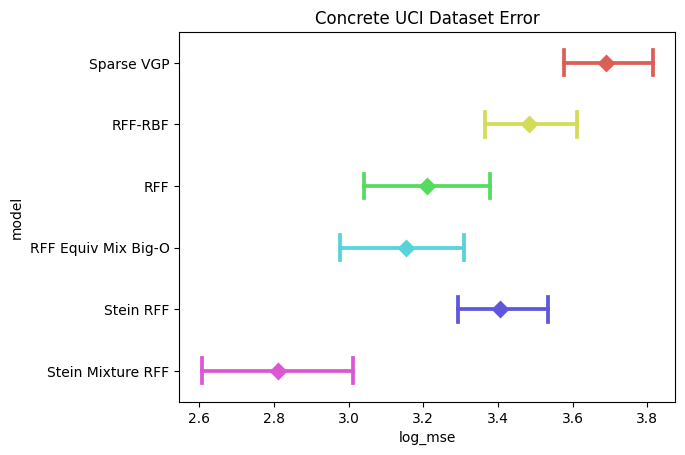

In [22]:
unique_models = res_df["model"].unique()
colors = sns.color_palette("hls", len(unique_models))

pointplot = sns.pointplot(
    data=res_df, x="log_mse", y="model", hue="model",
    errorbar="ci", capsize=.4,
    palette=colors, legend=False,
    color=".5", linestyle="none", marker="D",
)
pointplot.set_title("Concrete UCI Dataset Error")

## M-SRFR Learned Kernels

In [12]:
from steinRF.utils import mixture_pred_dists, plot_kernel_mixture, plot_mixture_preds

In [13]:
rff_gp, single_dist, mix_gp, mixture_dist, y_test = mixture_pred_dists(key, X, y, params, R=100, test_size=0.2)

In [14]:
sns.set_style("ticks")
sns.set_context("paper", rc={
    # 'font.size': 11,
    # "axes.labelsize": 12,
    'text.usetex': True,
    "font.family" : "serif",
    # "font.serif" : ["Times New Roman"],
    'text.latex.preamble': r'\usepackage{times}'
})

plt.rcParams.update({
    'font.size': 15,
    "axes.titlesize":15,
    "axes.labelsize": 12,
    'text.usetex': True,
    "font.family" : "serif",
    # "font.serif" : ["Times New Roman"],
    'text.latex.preamble': r'\usepackage{times}'
    # 'text.latex.preamble': r'\usepackage{amsfonts}; \usepackage{times}'
})

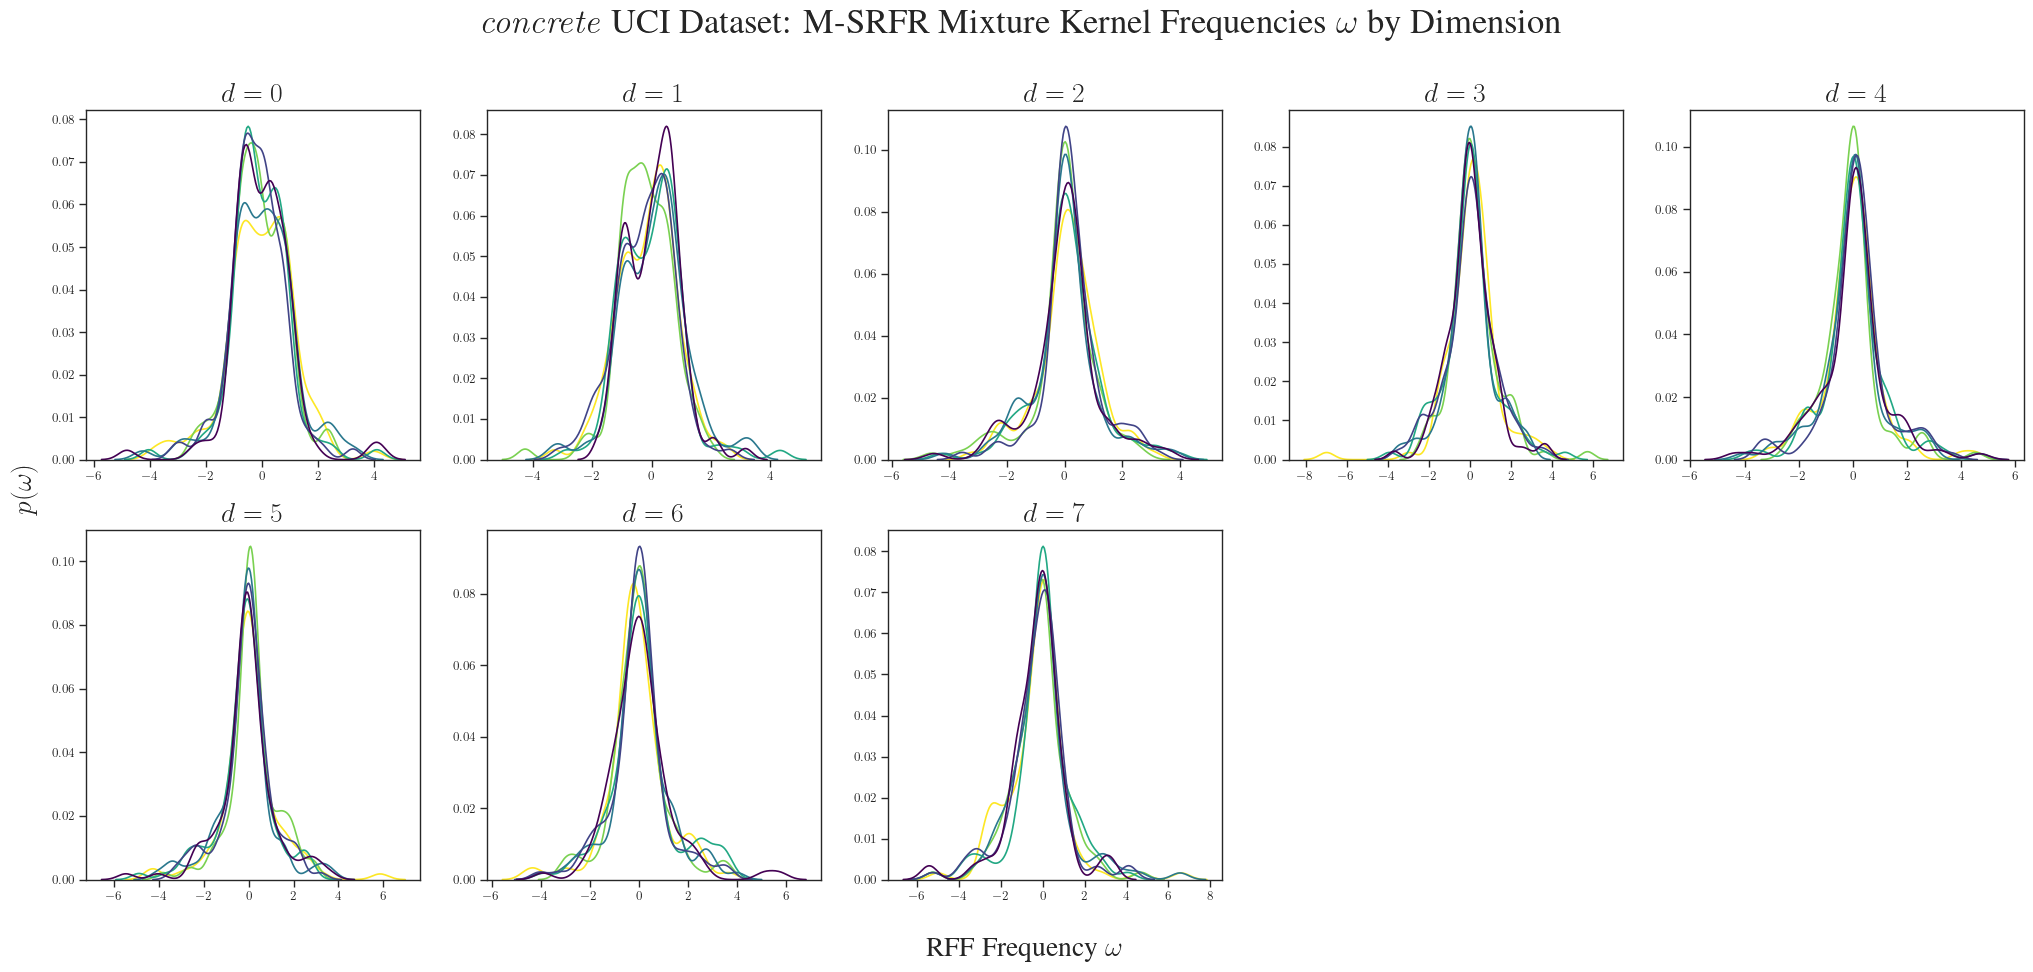

In [17]:
kernel_plot = plot_kernel_mixture(
    mix_gp.kernel.kernel.w, plots_per_row=5, bw_adjust=0.7, 
    title="$\\it{concrete}$ UCI Dataset: M-SRFR Mixture Kernel Frequencies $\omega$ by Dimension"
)
kernel_plot.savefig("../figures/concrete_kernel.pdf", bbox_inches="tight", dpi=300, format="pdf")

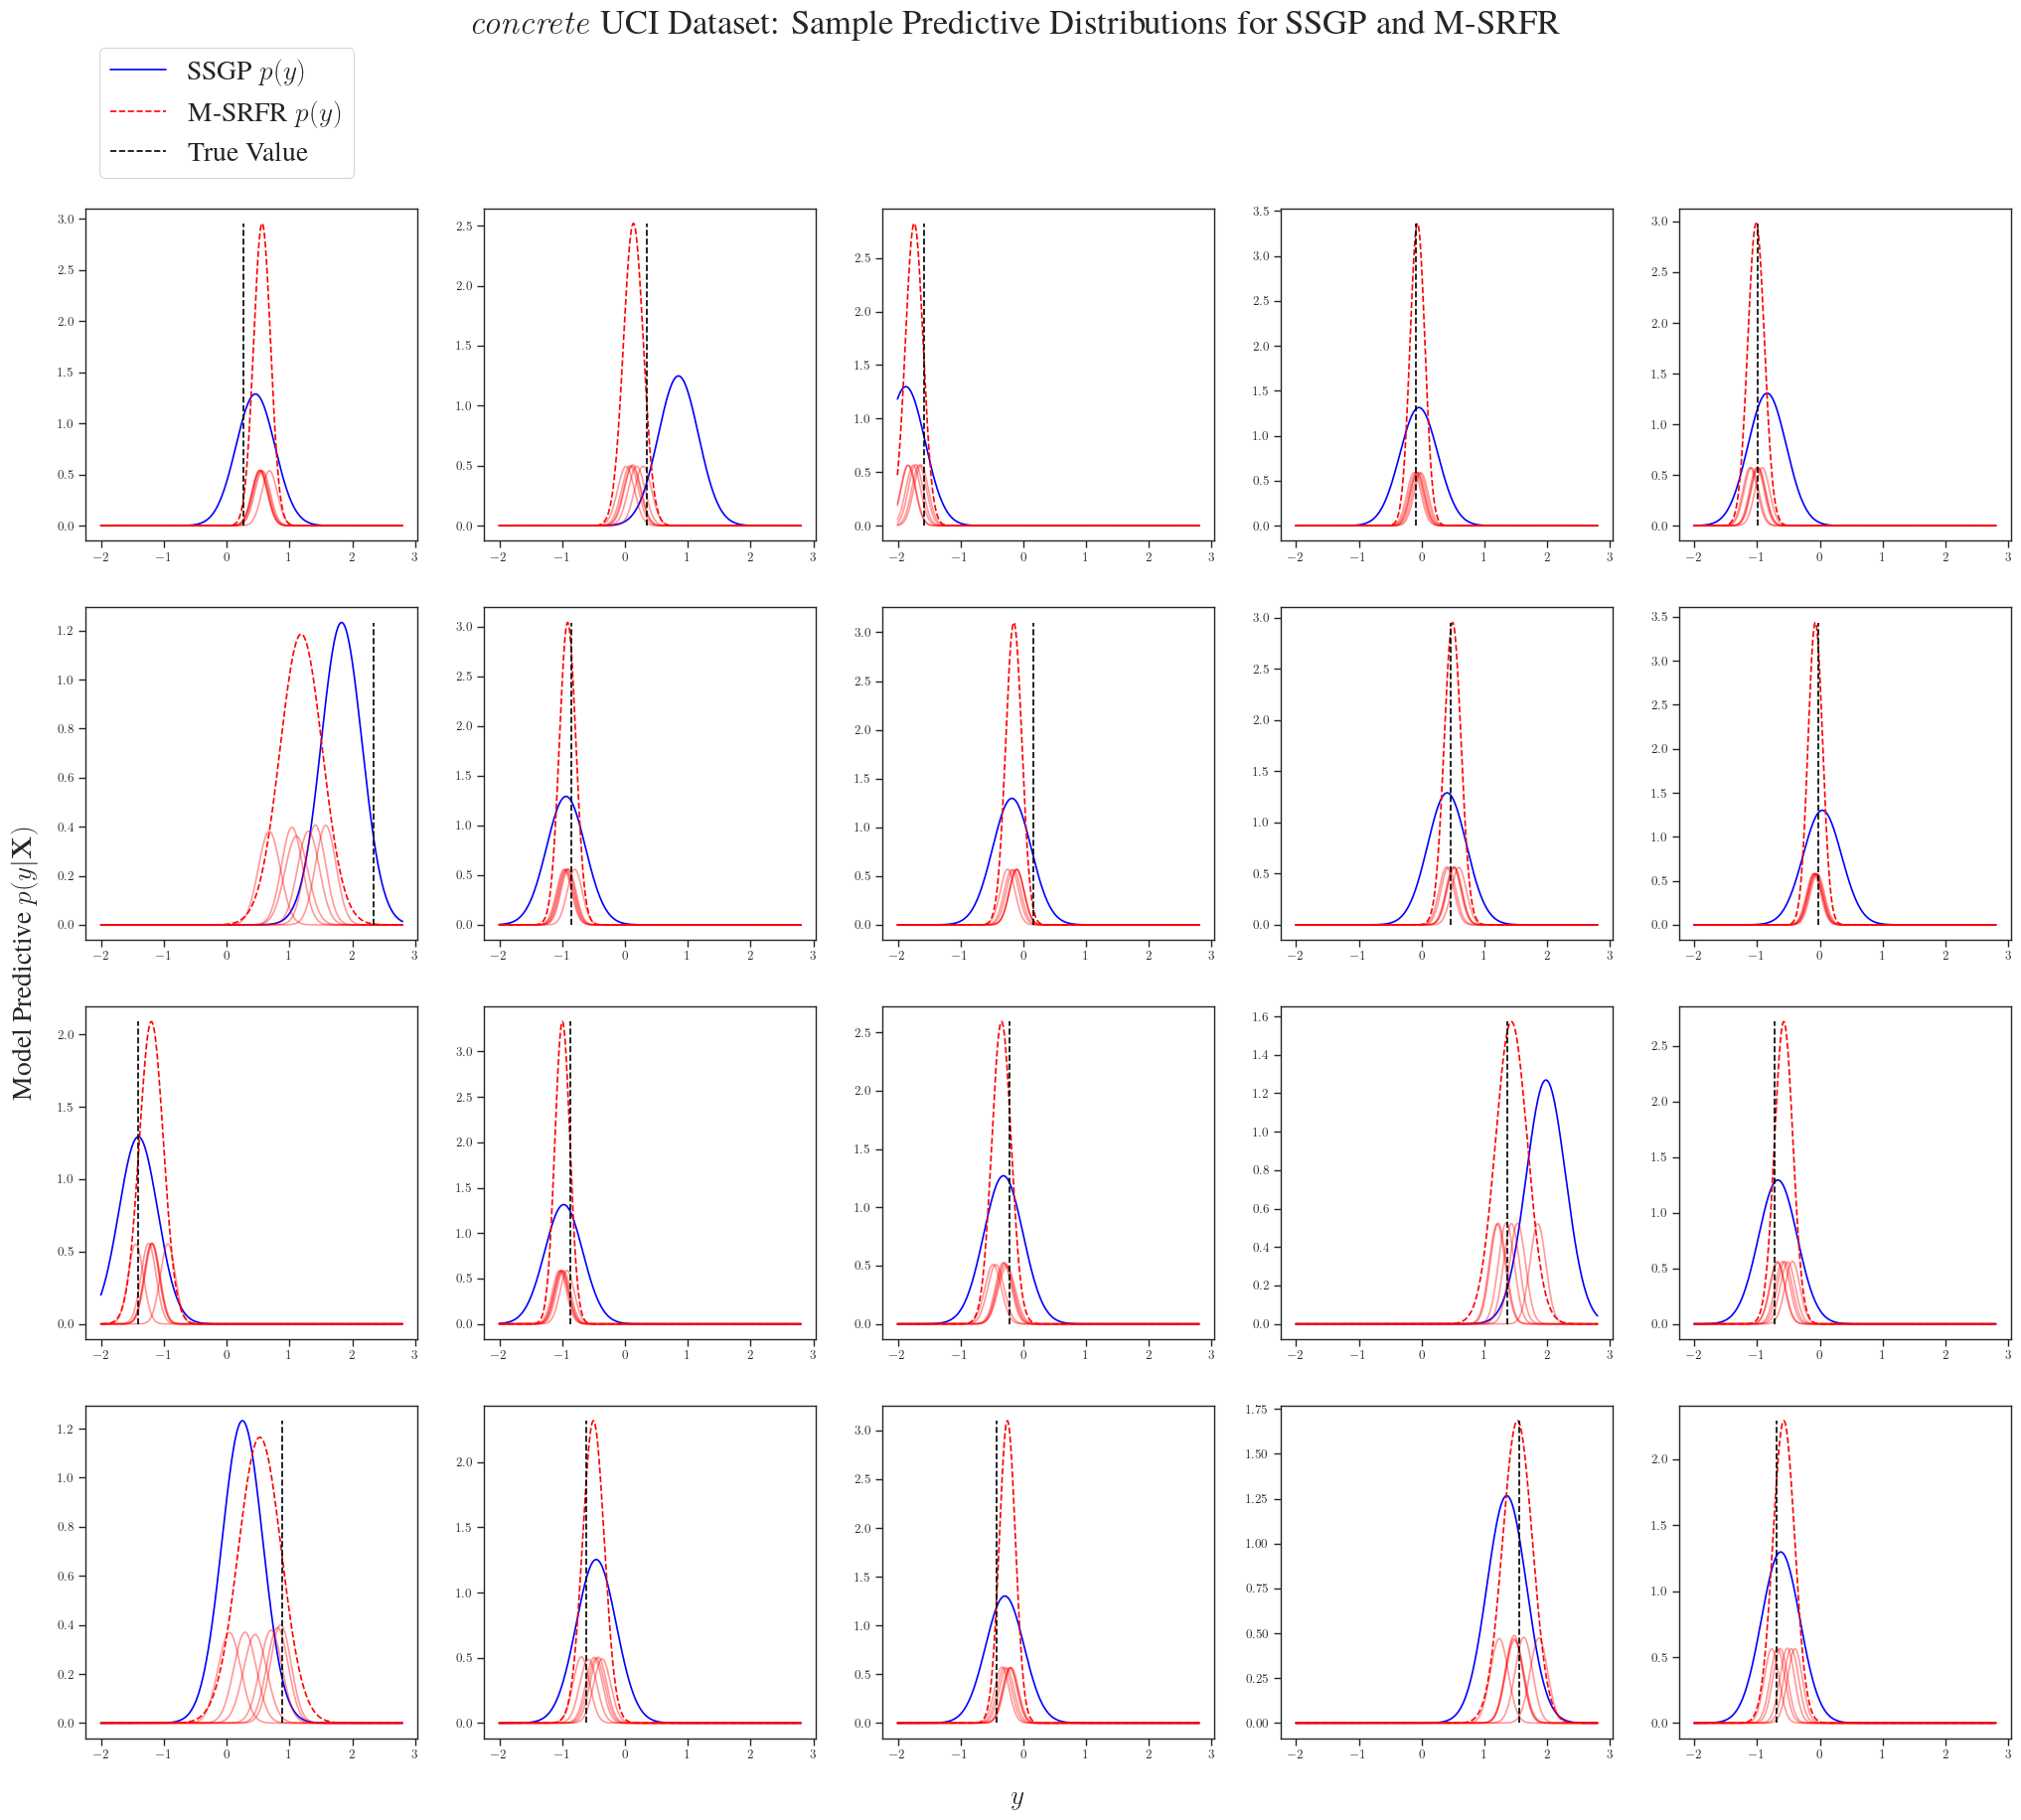

In [22]:
plot_key = jax.random.PRNGKey(2024)
plot_bounds = jnp.array([y.min(), y.max()])
pred_plot = plot_mixture_preds(
    single_dist, mixture_dist, y_test, n=20, 
    key=plot_key, standardize=False, bounds=plot_bounds,
    title="$\\it{concrete}$ UCI Dataset: Sample Predictive Distributions for SSGP and M-SRFR",
)
pred_plot.savefig("../figures/concrete_preds.pdf", bbox_inches="tight", dpi=300, format="pdf")